In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [7]:
def cal_area_theta(center_a,center_b,d,theta_l,theta_r,R):

    a = center_a
    b = center_b
    hl = R*np.sin(theta_l)+center_b
    hr = R*np.sin(theta_r)+center_b
    r = R

    theta = theta_l - theta_r

    point_1 = (hl * a) / (hl - b)

    point_2 = d + (a - d) * hr / (hr - b)

    fan_shape = 0.5 * theta * (pow(r,2))

    triangle_1 = 0.5 * point_1 * hl

    triangle_2 = 0.5 * (d - point_2) * hr

    triangle_3 = 0.5 * (point_2 - point_1) * b

    area = fan_shape + triangle_1 + triangle_2 + triangle_3

    # print(f'theta_1: {math.degrees(theta_1)} theta_2: {math.degrees(theta_2)} theta: {math.degrees(theta)}')

    return area

In [8]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Define contact line velocity
# theta_0 : equilibrium contact angle
# theta_d : dynamic contact angle
def fun_contact_line_velocity( f_c,i_t,theta_0, theta_d ):
    return (1/f_c)*i_t*(tf.cos(theta_0)-tf.cos(theta_d))

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
p_f_c = tf.constant(-2.02, dtype=DTYPE) # positive_friction_coefficient
n_f_c = tf.constant(-5.64, dtype=DTYPE) # nagative_friction_coefficient
i_t = tf.constant(7.64, dtype=DTYPE) #interfacial tension between the two liquids
d = tf.constant(0.000321, dtype=DTYPE) #gab
vl = tf.constant(fun_contact_line_velocity(n_f_c ,i_t,1.6406095000, 0.9745209500), dtype=DTYPE)
vr = tf.constant(fun_contact_line_velocity(n_f_c ,i_t,1.0874056000, 1.8590153000), dtype=DTYPE)

#initial_data = [a0 ,b0,r0 ,theta_l0,theta_r0 ]
initial_data = [-0.0000566758,-0.0006874250504951296,0.000704,1.500983153589793,1.0874056000]

# Define residual of the condition
def fun_r(yl_t , yr_t ,vl,vr,area_t):
    return (yl_t-vl) + (yr_t-vr) + area_t

In [9]:
# time interval
time = [0.0,0.0280]
# start_time
start_time= tf.constant(time[0], shape=(1,1),dtype=DTYPE)
# last_time
end_time = tf.constant(time[1], shape=(1,1),dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

t_data = tf.random.uniform(shape=[1,100],minval=0.0,maxval=0.0280, dtype=DTYPE)
t_data = tf.reshape(t_data,shape=(-1,1))

#t_data = tf.linspace(0.0,0.0280,100)
#t_data = tf.reshape(t_data,shape=(-1,1))

t_data = tf.concat([start_time,t_data],axis=0)
t_data = tf.concat([t_data,end_time],axis=0)
t_data = tf.constant(t_data,dtype=DTYPE)

In [10]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh',kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh',kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh',kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh',kernel_initializer='glorot_normal'),
    tf.keras.layers.Dense(units = 5)
])

NN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                64        
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 3,397
Trainable params: 3,397
Non-trainable params: 0
_________________________________________________________________


optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [11]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [14]:
def ode_system(t_data,vl,vr ,net):
    # t = t.reshape(-1,1)
    # t = tf.constant(t, dtype = tf.float32)
    # t_0 = tf.zeros((1,1))
    # one = tf.ones((1,1))
    #
    # with tf.GradientTape() as tape:
    #     tape.watch(t)
    #
    #     u = net(t)
    #     u_t = tape.gradient(u, t)
    #
    # ode_loss = u_t - tf.math.cos(2*np.pi*t)
    # IC_loss = net(t_0) - one

    t_0 = tf.zeros((1,1))

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t = t_data

        # Variables t and x are watched during tape
        tape.watch(t)

        # Determine residual
        u = net(t_data)
        a = tf.reshape(u[:,0],shape=(-1,1))
        b = tf.reshape(u[:,1],shape=(-1,1))
        R = tf.reshape(u[:,2],shape=(-1,1))
        theta_l =tf.reshape(u[:,3],shape=(-1,1))
        theta_r = tf.reshape(u[:,4],shape=(-1,1))

        yl = R*np.sin(theta_l)+b
        yr = R*np.sin(theta_r)+b
        area = cal_area_theta(a,b,d,theta_l,theta_r,R)

        yl_t = tape.gradient(yl, t)
        yr_t = tape.gradient(yr, t)
        area_t = tape.gradient(area, t)

    ode_loss = tf.reduce_mean(tf.square((yl_t-vl+yr_t-vr+vr+area_t)))

    pred_a = tf.reshape(u[:,0],shape=(-1,1))
    pred_b = tf.reshape(u[:,1],shape=(-1,1))
    pred_R = tf.reshape(u[:,2],shape=(-1,1))
    pred_theta_l =tf.reshape(u[:,3],shape=(-1,1))
    pred_theta_r = tf.reshape(u[:,4],shape=(-1,1))

    IC_loss = tf.reduce_mean(tf.square(initial_data[0] - pred_a))
    IC_loss += tf.reduce_mean(tf.square(initial_data[1] - pred_b))
    IC_loss += tf.reduce_mean(tf.square(initial_data[2] - pred_R))
    IC_loss += tf.reduce_mean(tf.square(initial_data[3] - pred_theta_l))
    IC_loss += tf.reduce_mean(tf.square(initial_data[4] - pred_theta_r))

    total_loss = ode_loss+IC_loss

    del tape

    return total_loss

nan
nan
nan
nan
nan
nan


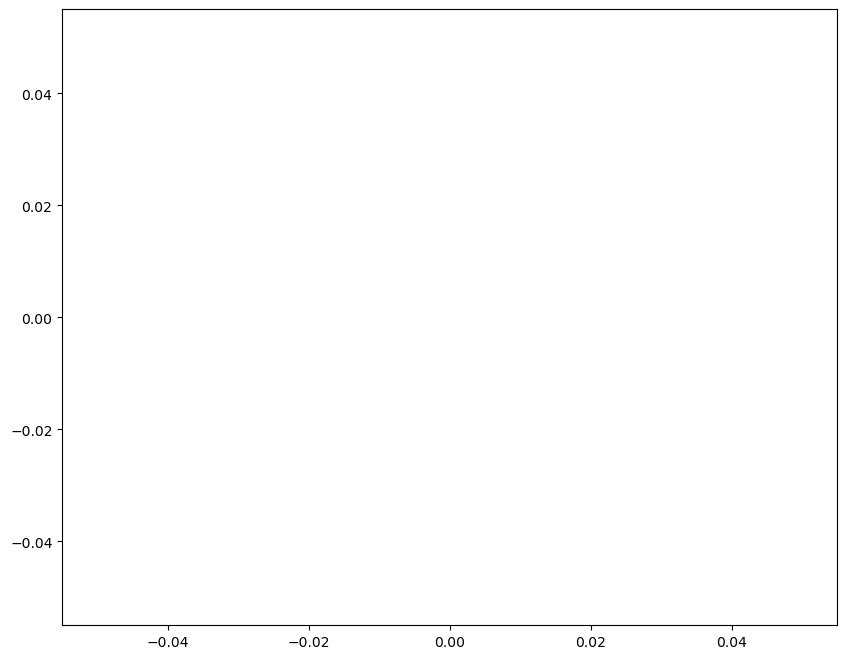

In [15]:
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(t_data,vl,vr ,NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

In [13]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
print(test_t)
pred_u = NN.predict(test_t).ravel()
print(pred_u)

#plt.figure(figsize = (10,8))
#plt.plot(train_t, train_u, 'ok', label = 'Train')
#plt.plot(test_t, true_u, '-k',label = 'True')
#plt.plot(test_t, pred_u, '--r', label = 'Prediction')
#plt.legend(fontsize = 15)
#plt.xlabel('t', fontsize = 15)
#plt.ylabel('u', fontsize = 15)
#plt.show()

[0.         0.02020202 0.04040404 0.06060606 0.08080808 0.1010101
 0.12121212 0.14141414 0.16161616 0.18181818 0.2020202  0.22222222
 0.24242424 0.26262626 0.28282828 0.3030303  0.32323232 0.34343434
 0.36363636 0.38383838 0.4040404  0.42424242 0.44444444 0.46464646
 0.48484848 0.50505051 0.52525253 0.54545455 0.56565657 0.58585859
 0.60606061 0.62626263 0.64646465 0.66666667 0.68686869 0.70707071
 0.72727273 0.74747475 0.76767677 0.78787879 0.80808081 0.82828283
 0.84848485 0.86868687 0.88888889 0.90909091 0.92929293 0.94949495
 0.96969697 0.98989899 1.01010101 1.03030303 1.05050505 1.07070707
 1.09090909 1.11111111 1.13131313 1.15151515 1.17171717 1.19191919
 1.21212121 1.23232323 1.25252525 1.27272727 1.29292929 1.31313131
 1.33333333 1.35353535 1.37373737 1.39393939 1.41414141 1.43434343
 1.45454545 1.47474747 1.49494949 1.51515152 1.53535354 1.55555556
 1.57575758 1.5959596  1.61616162 1.63636364 1.65656566 1.67676768
 1.6969697  1.71717172 1.73737374 1.75757576 1.77777778 1.79797

In [8]:
t_0 = tf.zeros((1,1))
print(t_0)

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


In [10]:
print(test_t)

[0.         0.02020202 0.04040404 0.06060606 0.08080808 0.1010101
 0.12121212 0.14141414 0.16161616 0.18181818 0.2020202  0.22222222
 0.24242424 0.26262626 0.28282828 0.3030303  0.32323232 0.34343434
 0.36363636 0.38383838 0.4040404  0.42424242 0.44444444 0.46464646
 0.48484848 0.50505051 0.52525253 0.54545455 0.56565657 0.58585859
 0.60606061 0.62626263 0.64646465 0.66666667 0.68686869 0.70707071
 0.72727273 0.74747475 0.76767677 0.78787879 0.80808081 0.82828283
 0.84848485 0.86868687 0.88888889 0.90909091 0.92929293 0.94949495
 0.96969697 0.98989899 1.01010101 1.03030303 1.05050505 1.07070707
 1.09090909 1.11111111 1.13131313 1.15151515 1.17171717 1.19191919
 1.21212121 1.23232323 1.25252525 1.27272727 1.29292929 1.31313131
 1.33333333 1.35353535 1.37373737 1.39393939 1.41414141 1.43434343
 1.45454545 1.47474747 1.49494949 1.51515152 1.53535354 1.55555556
 1.57575758 1.5959596  1.61616162 1.63636364 1.65656566 1.67676768
 1.6969697  1.71717172 1.73737374 1.75757576 1.77777778 1.79797

In [3]:
-0.0042040714285714285*0.0281

-0.00011813440714285714

In [4]:
0.004339750000000001*0.0281-0.000091020

3.0926975000000016e-05

In [8]:
vl = -0.0001192152 / 0.0282
print(vl)

-0.0042274893617021275


In [10]:
vr = (0.0000324229+0.0000910203) / 0.0282
print(vr)

0.004377418439716312


C:\Users\SongChihun\AppData\Local\Temp\ipykernel_24384\469857012.py:17: RuntimeWarning: invalid value encountered in sqrt
  y = yc + np.sqrt(r**2 - (x - xc)**2)


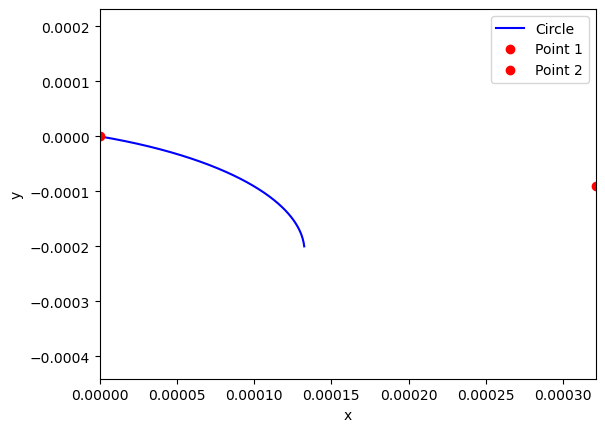

In [1]:
import numpy as np
import matplotlib.pyplot as plt
a1 = 0.0
a2 = 0.321/1000
b1 = 0.0
b2 = -0.0000910203
xc = -0.00009899662236288189
yc = -0.00020933714516341
# Define the x-range of the plot
xmin, xmax = a1, a2
x = np.linspace(xmin, xmax, 1000)

# Calculate the radius of the circle
r = np.sqrt((xc - a1)**2 + (yc - b1)**2)

# Calculate the y-values of the circle
y = yc + np.sqrt(r**2 - (x - xc)**2)

# Plot the circle
plt.plot(x, y, 'b-', label='Circle')

# Plot the two points above the circle
plt.plot(a1, b1, 'ro', label='Point 1')
plt.plot(a2, b2, 'ro', label='Point 2')

# Add axis labels and a legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Set the x-limits and y-limits of the plot
plt.xlim(xmin, xmax)
plt.ylim(yc - r, np.max([b1, b2]) + r)

# Show the plot
plt.show()